In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from transformers import BertTokenizer, BertForSequenceClassification
warnings.filterwarnings("ignore")

In [8]:
# Section 3: Load Dataset
# Make sure your CSV file has columns: text_en, text_hi, text_de, text_fr, label (0=ham, 1=spam)
df = pd.read_csv("/Users/aniketsingh/Downloads/multilingual.csv")  # Replace with your actual path


In [10]:
print(df.columns)


Index(['labels', 'text', 'text_hi', 'text_de', 'text_fr'], dtype='object')


In [11]:
df.rename(columns={'labels': 'label'}, inplace=True)

In [12]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return text.lower().strip()

for col in ['text', 'text_hi', 'text_de', 'text_fr']:
    df[col] = df[col].fillna("").apply(clean_text)


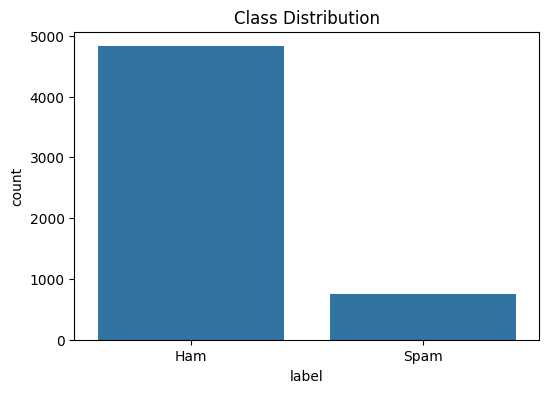

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x="label", data=df)
plt.title("Class Distribution")
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()


🔍 Training Gradient Boosting
📊 Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.70      0.82       149

    accuracy                           0.96      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115



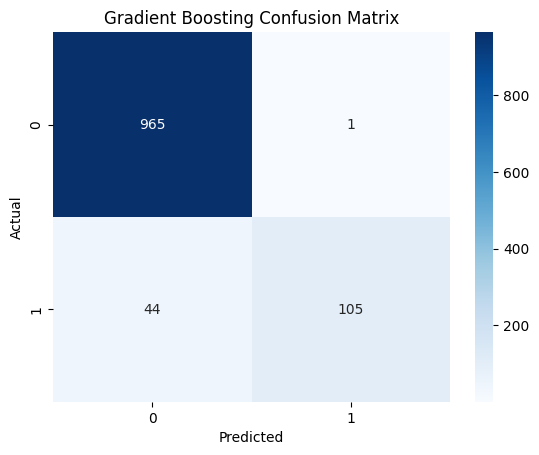


🔍 Training Random Forest
📊 Random Forest Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.82      0.90       149

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115



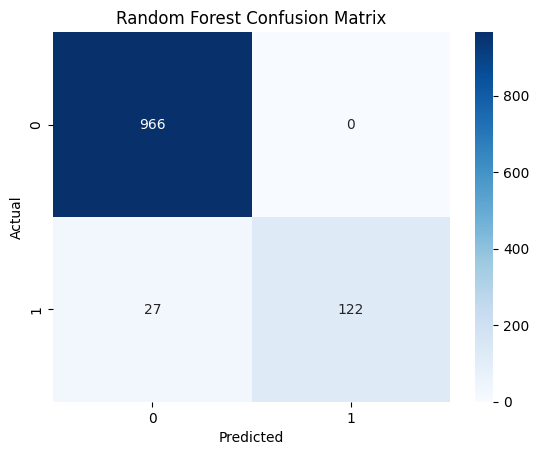


🔍 Training Logistic Regression
📊 Logistic Regression Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.97      0.96      1115



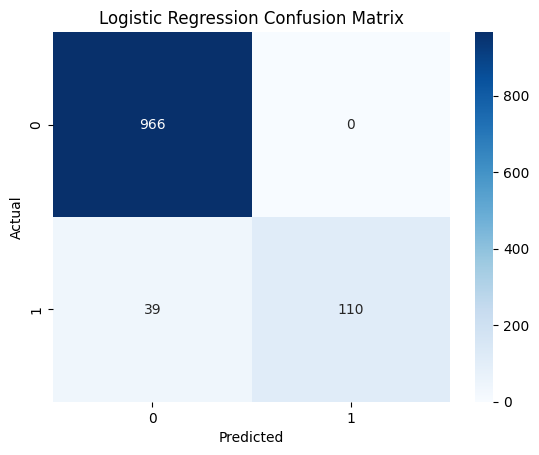

In [16]:
X = df['text']
y = df['label']

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

models = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

for name, model in models.items():
    print(f"\n🔍 Training {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(f"📊 {name} Classification Report:")
    print(classification_report(y_test, preds))
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [17]:
print("\n🤖 Loading Pretrained mBERT for Spam Inference...")
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

def classify_mbert(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    return "Spam" if torch.argmax(probs).item() == 1 else "Not Spam"

# Section 9: Test mBERT on multilingual inputs
print("\n🌍 Testing mBERT on multilingual inputs:\n")
samples = [
    df['text'].iloc[0],      # English
    df['text_hi'].iloc[0],   # Hindi
    df['text_de'].iloc[0],   # German
    df['text_fr'].iloc[0],   # French
]

for text in samples:
    prediction = classify_mbert(text)
    print(f"{text} → {prediction}")


🤖 Loading Pretrained mBERT for Spam Inference...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🌍 Testing mBERT on multilingual inputs:

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat → Not Spam
dakag      bag non   cag       wack → Not Spam
gehen sie bis jurong punkt verrckt verfgbar nur in buggis n great world la e buffet cine there got amore wat → Not Spam
allez jusqu jurong point fou disponible seulement dans bugis n grand monde la e buffet cine il y a eu plus → Not Spam
